In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from tensorflow import keras
import pandas as pd
import random

In [2]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  tf.experimental.numpy.random.seed(seed)

set_seed()
project_dir = os.path.dirname(os.getcwd())

In [3]:
model_mn2 = keras.applications.MobileNetV2(
    input_shape=None, alpha=1.0, include_top=True, weights='imagenet',
    input_tensor=None, pooling=None, classes=1000
)
layer_name = 'block_15_add'
feature_extractor = keras.models.Model(inputs=model_mn2.input, outputs=model_mn2.get_layer(layer_name).output)

In [4]:
models_path = os.path.join(project_dir, 'models')
model_mobilenetv2_regularized = tf.keras.models.load_model(os.path.join(models_path, 'model_mobilenetv2_regularized_pvd'))
model_squeeze_excite_resnet = tf.keras.models.load_model(os.path.join(models_path, 'model_squeeze_excite_resnet_plantvillage'))
model_pca_based = tf.keras.models.load_model(os.path.join(models_path, 'model_pca_based_plantvillage'))

In [5]:
diseases_names = []
dataset_path = os.path.join(project_dir, 'datasets', 'encoded', 'PlantVillage')

for diseases in os.listdir(os.path.join(dataset_path, 'train')):
    diseases_names += [diseases.split('.npy')[0]]

diseases_names.sort()
plant_name_to_id = {plant: i for i, plant in enumerate(diseases_names)}

In [6]:
instances = {}
labels = {}

for set_kind in ["test", "train", "val"]:
    X_per_class = []
    y_per_class = []

    for i, file in enumerate(os.listdir(os.path.join(dataset_path, set_kind))):
        print(f"\r[{i}] {set_kind}/{file}", end='')
        plants_encoded = np.load(os.path.join(dataset_path, set_kind, file))
        plant_name = file.split('.npy')[0]

        X_per_class += [plants_encoded.reshape([plants_encoded.shape[0], 49, 160])]
        y_per_class += [plant_name_to_id[plant_name] for _ in range(plants_encoded.shape[0])]

    instances[set_kind] = np.concatenate(X_per_class)
    labels[set_kind] = np.array(y_per_class)

[38] val/Tomato___Tomato_Yellow_Leaf_Curl_Virus.npyite.npypy

In [7]:
n_classes = len(diseases_names)

X_train = instances['train']
y_train = np.eye(n_classes)[labels['train']]


X_valid = instances['val']
y_valid = np.eye(n_classes)[labels['val']]

X_test = instances['test']
y_test = np.eye(n_classes)[labels['test']]

In [8]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.image import random_crop
from tensorflow.image import random_contrast
from tensorflow.image import random_brightness
from tensorflow.image import random_flip_left_right
from tensorflow.image import random_hue
from tensorflow.image import random_jpeg_quality
from tensorflow.image import random_saturation
from tensorflow.errors import InvalidArgumentError
import matplotlib.pyplot as plt

In [9]:
def get_crop_size(img, minprop=0.7):
    def rand_prop(x):
        return x + (1. - x) * np.random.random()

    height, width, chanells = img.shape
    height_prop = 1.
    width_prop = 1.

    if height > width:
        height_prop = rand_prop(minprop)
        width_prop = rand_prop(height_prop)
    else:
        width_prop = rand_prop(minprop)
        height_prop = rand_prop(width_prop)

    height = np.floor(height_prop * height).astype(int)
    width = np.floor(width_prop * width).astype(int)
    return (height, width, chanells)

In [9]:
def apply_random_transforms(img):
    img = random_rotation(img, 20, row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect')
    img = random_contrast(img, 0.8, 1.2)
    img = random_brightness(img, 0.08)
    img = random_hue(img, 0.025)
    img = random_saturation(img, 0.85, 1.15)
    img = random_jpeg_quality(img, 75, 95)
    img = random_flip_left_right(img)
    return random_crop(img, get_crop_size(img, 0.67)).numpy()

def get_augmented_image(img):
    return Image.fromarray(apply_random_transforms(np.array(img.convert('RGB')))).resize((224, 224))

In [10]:
test_path = os.path.join(project_dir, 'datasets', 'augmented', 'PlantVillage', 'test')
all_dirs = []
for directory in os.listdir(test_path):
    all_dirs += [directory]

In [13]:
for i, disease in enumerate(all_dirs):
    print("[{:03}] '{}'".format(i, disease))
    original_photos = []
    photos_names = []

    for j, file in enumerate(os.listdir(os.path.join(test_path, disease))):
        with Image.open(os.path.join(test_path, disease, file)) as img:
            original_photos += [img.copy()]
            photos_names += [os.path.join(test_path, disease, file)]


    dest = os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease)
    os.makedirs(os.path.dirname(dest), exist_ok=True)

    for j, img in enumerate(original_photos):
        print("\rPhoto no: {}".format(j), end='')
        os.makedirs(os.path.dirname(dest + "/{}/".format(j)), exist_ok=True)
        for counter in range(1, 20+1):
            try:
                get_augmented_image(img).save(
                    dest + "/{}/{}_{}.jpg".format(j, disease.replace(' ', '_'), counter)
                )
                print("\r{}".format(counter), end='')
            except Exception as e:
                print("\nError encountered: ", photos_names[j])
                print(e)

[000] 'Tomato___Leaf_Mold'
20[001] 'Tomato___Septoria_leaf_spot'
20[002] 'Tomato___Spider_mites Two-spotted_spider_mite'
20[003] 'Tomato___Target_Spot'
20[004] 'Tomato___Tomato_mosaic_virus'
20[005] 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
20oto no: 1071

In [11]:
model_mnv2 = keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3), dtype=tf.uint8),
    keras.layers.Lambda(lambda x: tf.cast(x, dtype=tf.float32)),
    keras.layers.Lambda(
        tf.keras.applications.mobilenet_v2.preprocess_input,
        name='preprocessing',
        input_shape=(224, 224, 3),
        dtype=tf.float32),
    feature_extractor,
    model_mobilenetv2_regularized
])

In [12]:
model_seresnet = keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3), dtype=tf.uint8),
    keras.layers.Lambda(lambda x: tf.cast(x, dtype=tf.float32)),
    keras.layers.Lambda(
        tf.keras.applications.mobilenet_v2.preprocess_input,
        name='preprocessing',
        input_shape=(224, 224, 3),
        dtype=tf.float32),
    feature_extractor,
    model_squeeze_excite_resnet
])

In [13]:
pca_per_filter = [
    PCA(n_components=5).fit(X_train[..., i])
    for i in range(X_train.shape[-1])
]

class PCATransformer(keras.layers.Layer):
    def __init__(self, means, components, **kwargs):
        super().__init__(**kwargs)
        self.all_means = tf.reshape(tf.transpose(means), [1, 49, 160])
        self.all_components = tf.transpose(components, perm=[0, 2, 1])

    @tf.function
    def call(self, X):
        return tf.transpose(tf.map_fn(
            lambda inp: inp[0] @ inp[1],
            (tf.transpose(X - self.all_means, perm=[2, 0, 1]), self.all_components),
            fn_output_signature=tf.TensorSpec(shape=[None, 5])
        ), perm=[1, 2, 0])

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape((batch_input_shape[0], 5, 160))

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "mean": self.means.numpy(), "components": self.components.numpy()}


all_means = np.array([filter.mean_ for filter in pca_per_filter])
all_components = np.array([filter.components_ for filter in pca_per_filter])

model_pcadense = keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3), dtype=tf.uint8),
    keras.layers.Lambda(lambda x: tf.cast(x, dtype=tf.float32)),
    keras.layers.Lambda(
        tf.keras.applications.mobilenet_v2.preprocess_input,
        name='preprocessing',
        input_shape=(224, 224, 3),
        dtype=tf.float32),
    feature_extractor,
    keras.layers.Reshape(target_shape=[49, 160]),
    PCATransformer(tf.constant(all_means), tf.constant(all_components)),
    keras.layers.Flatten(input_shape=[5, 160]),
    model_pca_based
])

In [16]:
hits_mnv2 = np.zeros((39, 20), dtype=np.int32)

for i, disease in enumerate(all_dirs):
    print("[{:03}] '{}'".format(i, disease))
    correct_id = plant_name_to_id[disease]

    for counter in os.listdir(os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease)):
        origin = os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease, counter)
        batch = tf.keras.utils.image_dataset_from_directory(origin, labels=None, batch_size=20, image_size=(224, 224))

        for x in batch.take(1):
            preds_proba = model_mnv2(x)
            preds = np.argmax(np.cumsum(np.sqrt(preds_proba.numpy()), axis=0), axis=1)
            hit_or_miss = np.where(preds == correct_id, 1, 0)
            hits_mnv2[correct_id] += hit_or_miss

[000] 'Apple___Apple_scab'
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes

In [17]:
hits_seresnet = np.zeros((39, 20), dtype=np.int32)

for i, disease in enumerate(all_dirs):
    print("[{:03}] '{}'".format(i, disease))
    correct_id = plant_name_to_id[disease]

    for counter in os.listdir(os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease)):
        origin = os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease, counter)
        batch = tf.keras.utils.image_dataset_from_directory(origin, labels=None, batch_size=20, image_size=(224, 224))

        for x in batch.take(1):
            preds_proba = model_mnv2(x)
            preds = np.argmax(np.cumsum(np.sqrt(preds_proba.numpy()), axis=0), axis=1)
            hit_or_miss = np.where(preds == correct_id, 1, 0)
            hits_seresnet[correct_id] += hit_or_miss

[000] 'Apple___Apple_scab'
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes

In [18]:
hits_pca = np.zeros((39, 20), dtype=np.int32)

for i, disease in enumerate(all_dirs):
    print("[{:03}] '{}'".format(i, disease))
    correct_id = plant_name_to_id[disease]

    for counter in os.listdir(os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease)):
        origin = os.path.join(os.path.abspath(os.path.join(test_path, os.pardir)), 'ensemble_test_aug', disease, counter)
        batch = tf.keras.utils.image_dataset_from_directory(origin, labels=None, batch_size=20, image_size=(224, 224))

        for x in batch.take(1):
            preds_proba = model_mnv2(x)
            preds = np.argmax(np.cumsum(np.sqrt(preds_proba.numpy()), axis=0), axis=1)
            hit_or_miss = np.where(preds == correct_id, 1, 0)
            hits_pca[correct_id] += hit_or_miss

[000] 'Apple___Apple_scab'
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes

In [29]:
count_images = 0

for i, disease in enumerate(all_dirs):
    print("[{:03}] '{}'".format(i, disease))
    correct_id = plant_name_to_id[disease]

    count_images +=  len(os.listdir(os.path.join(test_path, disease)))

print(count_images)

[000] 'Apple___Apple_scab'
[001] 'Apple___Black_rot'
[002] 'Apple___Cedar_apple_rust'
[003] 'Apple___healthy'
[004] 'Background_without_leaves'
[005] 'Blueberry___healthy'
[006] 'Cherry___healthy'
[007] 'Cherry___Powdery_mildew'
[008] 'Corn___Cercospora_leaf_spot Gray_leaf_spot'
[009] 'Corn___Common_rust'
[010] 'Corn___healthy'
[011] 'Corn___Northern_Leaf_Blight'
[012] 'Grape___Black_rot'
[013] 'Grape___Esca_(Black_Measles)'
[014] 'Grape___healthy'
[015] 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
[016] 'Orange___Haunglongbing_(Citrus_greening)'
[017] 'Peach___Bacterial_spot'
[018] 'Peach___healthy'
[019] 'Pepper,_bell___Bacterial_spot'
[020] 'Pepper,_bell___healthy'
[021] 'Potato___Early_blight'
[022] 'Potato___healthy'
[023] 'Potato___Late_blight'
[024] 'Raspberry___healthy'
[025] 'Soybean___healthy'
[026] 'Squash___Powdery_mildew'
[027] 'Strawberry___healthy'
[028] 'Strawberry___Leaf_scorch'
[029] 'Tomato___Bacterial_spot'
[030] 'Tomato___Early_blight'
[031] 'Tomato___healthy'
[032

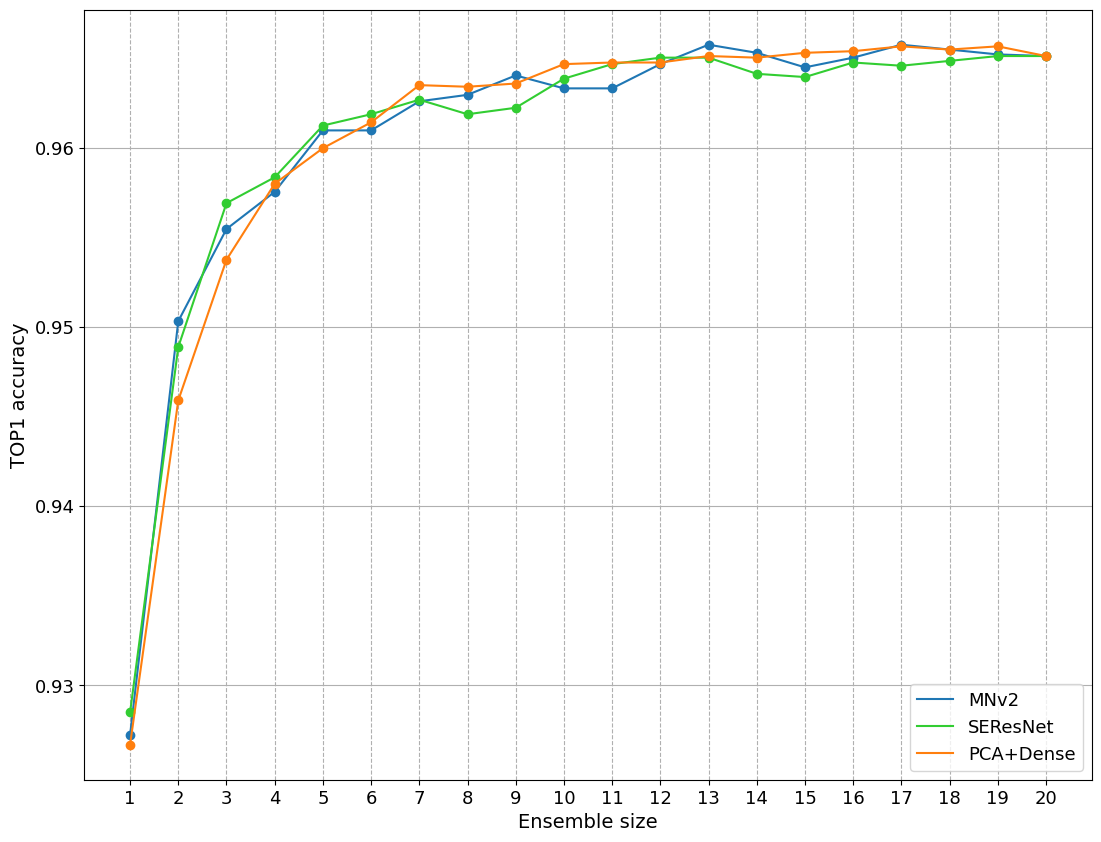

In [31]:
plt.figure(figsize=(13, 10))

plt.xlabel("Ensemble size", fontsize=14)
plt.ylabel("TOP1 accuracy", fontsize=14)

plt.xticks(range(1, 21), fontsize=13)
plt.yticks(np.arange(0.25, 0.97, 0.01), fontsize=13)
plt.grid(axis='x', linestyle='--')
plt.grid(axis='y', linestyle='-')

mnv2_acc = np.sum(hits_mnv2, axis=0) / count_images
plt.plot(range(1, 21), mnv2_acc, c="tab:blue", label="MNv2")
plt.scatter(range(1, 21), mnv2_acc, c="tab:blue", zorder=2)

seresnet_acc = np.sum(hits_seresnet, axis=0) / count_images
plt.plot(range(1, 21), seresnet_acc, c="limegreen", label="SEResNet")
plt.scatter(range(1, 21), seresnet_acc, c="limegreen", zorder=2)

pca_acc = np.sum(hits_pca, axis=0) / count_images
plt.plot(range(1, 21), pca_acc, c="tab:orange", label="PCA+Dense")
plt.scatter(range(1, 21), pca_acc, c="tab:orange", zorder=2)

plt.legend(fontsize=13, loc="lower right")
plt.savefig('plantvillage_ensamble.png')
plt.show()
